In [1]:
# This code block provides a function to read a pair of x,y numerical data columns from
# an input CSV file. It gracefully ignores all invalid lines before the first valid
# line, printing warnings if invalid lines are detected after the first valid one,
# or if no valid lines are found.
import csv
import numpy as np
import logging
def readCSVCleanXY(filename,xcol=0,ycol=1,yval=0.0):
    anyValid = False
    with open(filename, "r", newline='') as f:
        rdr = csv.reader(f,delimiter=',')
        rv = []
        for l in rdr:
            try:
                rv.append([float(l[xcol]),float(l[ycol] if not (ycol is None) else yval)])
                anyValid = True
            except (ValueError, IndexError):
                if anyValid:
                    logging.warning("Invalid line %s found.", l)
    if not anyValid:
        logging.warning("No valid data found!")
    return np.array(rv)

In [2]:
# This code block provides a powder diffraction simulation interface utilizing GSAS II
# (Scriptable) as a backend provider. It requires instrument parameter files that fully
# specify what is computed. Since we are not doing Rietveld refinements, but just simulating
# approximate patterns, we construct "approximate" constant wavelength inst parameter files 
# that do the job. The relevant control parameters are:
#   wl (in angstrom), or "CuKa" for Cu radiation (default)
#   radtype = "X" (X-ray), "S" (Synchroton X-ray), or "N" (Neutron)
import os,sys
from pathlib import Path
# Adding random paths to syspath is *very* bad practice. Unfortunately, it is needed
# since GSASII is not provided as a proper module.
sys.path.insert(0,str(Path(os.getcwd(),'/Users/lucaspressley/Xerus/Xerus/GSASII/')))
import GSASIIscriptable as G2sc

simulatePatternParams = {
    'CuKa': "#GSAS-II\nType:PXC;Bank:1\nLam1:1.5405;Lam2:1.5443;Zero:0.0;Polariz.:0.7;Azimuth:0.0;I(L2)/I(L1):0.5\nU:2.0;V:-2.0;W:5.0;X:0.0;Y:0.0;Z:0.0;SH/L:0.002\n",
    'X': "#GSAS-II\nType:PXC;Bank:1\nLam:{wl:.6f};Zero:0.0;Polariz.:0.7;Azimuth:0.0\nU:2.0;V:-2.0;W:5.0;X:0.0;Y:0.0;Z:0.0;SH/L:0.002\n",
    'S': "#GSAS-II\nType:PXC;Bank:1\nLam:{wl:.6f};Polariz.:0.99;Azimuth:0.0;Zero:0.0\nU:1.163;V:-0.126;W:0.063;X:0.0;Y:0.0;Z:0.0;SH/L:0.002\n",
    'N': "#GSAS-II\nType:PNC;Bank:1\nLam:{wl:.6f};Zero:0.0;Polariz.:0.0;Azimuth:0.0\nU:257.182710995;V:-640.525145369;W:569.378664828\nX:0.0;Y:0.0;Z:0.0;SH/L:0.002\n"
}

def simulatePattern(cif, th2min=5.0, th2max=60.0, th2step=0.01, instprm=None, wl="CuKa", radtype="X", tmpdir="/tmp", tmpname="tmp"):
    PPWrap = lambda pfix: Path(tmpdir,tmpname+pfix)
    # write required GSAS II input files to temporary location
    try:
        with open(cif, "r") as f:
            cif = f.read()
    except:
        # cif is already the contents of a file
        pass
    with open(PPWrap(".cif"), "w") as f:
        f.write(cif)
    with open(PPWrap(".instprm"), "w") as f:
        if wl == "CuKa":
            f.write(simulatePatternParams['CuKa'])
        else:
            f.write(simulatePatternParams[radtype].format(wl=wl))
    gpx = G2sc.G2Project(filename=PPWrap('.gpx')) # create a project
    # add a phase to the project
    phase0 = gpx.add_phase(PPWrap('.cif'), phasename="tmp")
    # add a simulated histogram and link it to the previous phase(s)
    hist1 = gpx.add_simulated_powder_histogram("Simulation", PPWrap(".instprm"),th2min,th2max,th2step,phases=gpx.phases())
    # Set the scale factor to adjust the y scale; needed to make sure it is "big"
    # relative to the background value of "1"
    hist1.SampleParameters['Scale'][0] = 1000000.
    # parameter optimization and calculate pattern
    gpx.data['Controls']['data']['max cyc'] = 0 # refinement not needed
    gpx.do_refinements([{}])
    gpx.save()
    # save results
    gpx.histogram(0).Export(PPWrap('_data'),'.csv','hist') # data
    gpx.histogram(0).Export(PPWrap('_refl'),'.csv','refl') # reflections
    # read results and return in dictionary
    rv = {}
    rv['pred'] = readCSVCleanXY(PPWrap('_data.csv'),ycol=3)
    rv['refl'] = readCSVCleanXY(PPWrap('_refl.csv'),xcol=4,ycol=None,yval=-0.05*np.amax(rv['pred'][:,1]))
    return rv

GSAS-II binary directory: /Users/lucaspressley/Xerus/Xerus/GSASII/bindist
7 values read from config file /Users/lucaspressley/Xerus/Xerus/GSASII/config.py


In [3]:
#
# Small helper function to compute required scale factor to keep maximum at same height
#
def getScaleFactor(data, scalecol=1, target=1000.0):
    return target/np.amax(data[:,scalecol])

/tmp/tmp.cif read by Reader CIF
gpx file saved as /tmp/tmp.gpx
Simulating 3209 points from 5.0 to 60.036768800000004 degrees 2theta
Instrument parameters read: /tmp/tmp.instprm (G2 fmt) bank 1
gpx file saved as /tmp/tmp.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 3178 with 3209 obs.
Read from file:/tmp/tmp.bak0.gpx
Save to file  :/tmp/tmp.gpx
GPX file save successful
 Refinement results are in file: /tmp/tmp.lst
 ***** Refinement successful *****
gpx file saved as /tmp/tmp.gpx
/tmp/tmp_refl.csv
PWDR Simulation reflections written to file /tmp/tmp_refl.csv
/tmp/tmp.cif read by Reader CIF
gpx file saved as /tmp/tmp.gpx
Simulating 3209 points from 5.0 to 60.036768800000004 degrees 2theta
Instrument parameters read: /tmp/tmp.instprm (G2 fmt) bank 1
gpx file saved as /tmp/tmp.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 3289.8 with 3209 obs.
Read from file:/tmp/tmp.bak0.gpx
Save to file  :/tmp/tmp.gpx
GPX file save successfu

<IPython.core.display.Javascript object>


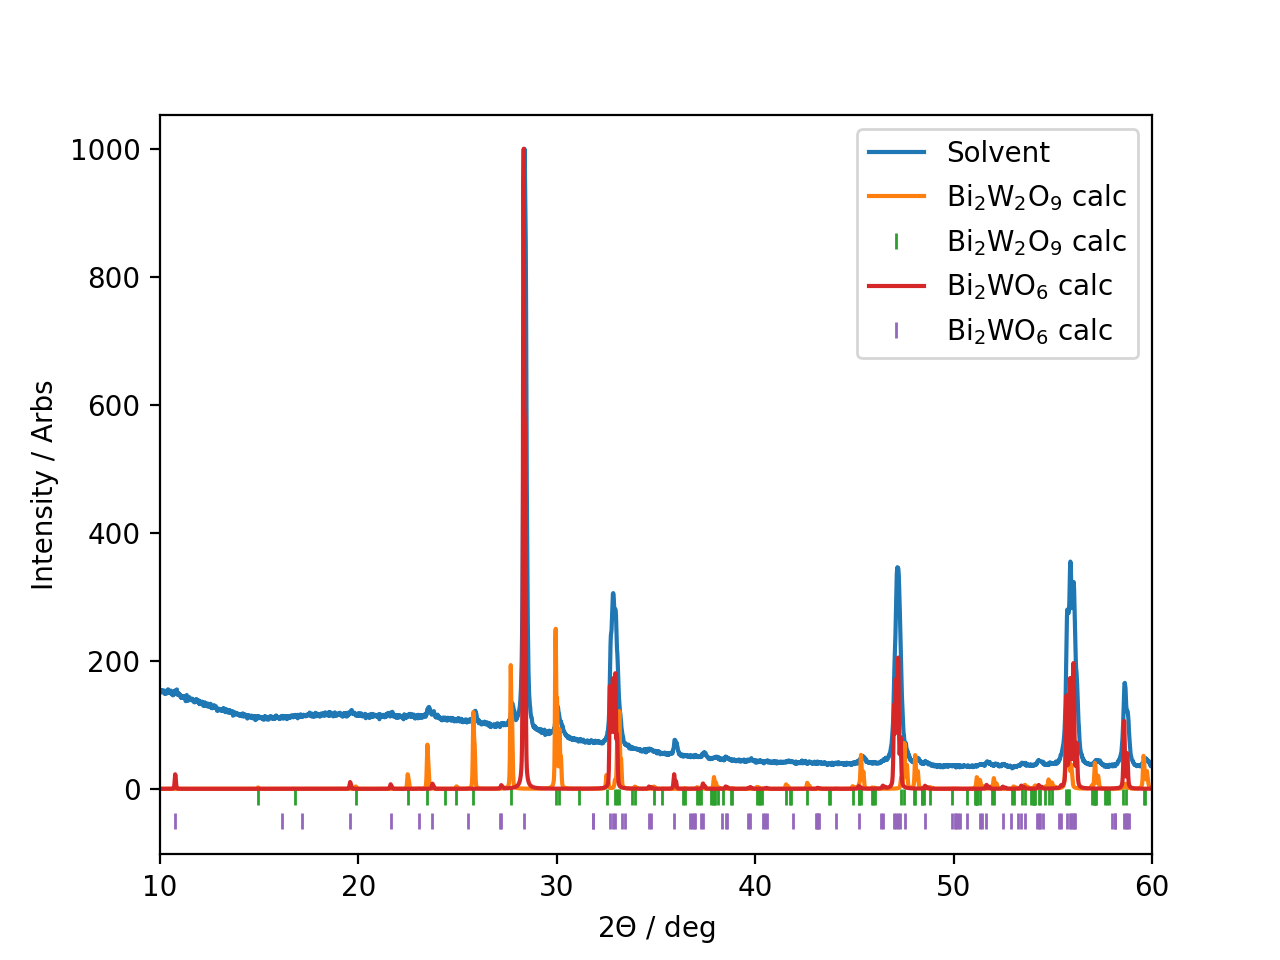

In [6]:
#
# This block shows reading a single experimental dataset and comparing
# it to a simulated one. Appropriately scales all to the same maximum value.
#
# Any errors related to inability to load module "wx" are inert and arise because
# we are running GSASII in scripted mode.
#
%matplotlib notebook
import matplotlib.pyplot as plt
data = readCSVCleanXY("PDC_LDFZ_20200723_2_217_1_4h-BWO-ttipoffeedrod-solvent.csv")
# Use 2-Theta min, max, and minimum step size as experimental data
sim = simulatePattern("c8ce00189h2.cif",th2min=np.amin(data[:,0]),th2max=np.amax(data[:,0]),th2step=np.amin(np.diff(data[:,0])))
sim2 = simulatePattern("xs3185a_FZ.cif",th2min=np.amin(data[:,0]),th2max=np.amax(data[:,0]),th2step=np.amin(np.diff(data[:,0])))
osf = getScaleFactor(data)
plt.plot(data[:,0],osf*data[:,1],label="Solvent")
osf = getScaleFactor(sim['pred'])
plt.plot(sim['pred'][:,0],0.25*osf*sim['pred'][:,1],label="Bi$_2$W$_2$O$_9$ calc")
plt.plot(sim['refl'][:,0],0.25*osf*sim['refl'][:,1], '|', label="Bi$_2$W$_2$O$_9$ calc")
osf = getScaleFactor(sim2['pred'])
plt.plot(sim2['pred'][:,0],osf*sim2['pred'][:,1],label="Bi$_2$WO$_6$ calc")
plt.plot(sim2['refl'][:,0],osf*sim2['refl'][:,1], '|', label="Bi$_2$WO$_6$ calc")
plt.xlabel("2$\mathrm{\Theta}$ / deg")
plt.ylabel("Intensity / Arbs")
plt.xlim(10,60)
plt.legend()
plt.savefig('BWO-solvent.png',dpi=200)

/tmp/tmp.cif read by Reader CIF
Atom type Zr+3 not found, using Zr
Atom type P-3 not found, using P
Atom type P-3 not found, using P
gpx file saved as /tmp/tmp.gpx
Instrument parameters read: /tmp/tmp.instprm (G2 fmt) bank 1
gpx file saved as /tmp/tmp.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
Found 0 SVD zeros
Read from file:/tmp/tmp.bak0.gpx
Save to file  :/tmp/tmp.gpx
GPX file save successful
 Refinement results are in file: /tmp/tmp.lst
 ***** Refinement successful *****
gpx file saved as /tmp/tmp.gpx
/tmp/tmp_refl.csv
PWDR Simulation reflections written to file /tmp/tmp_refl.csv


<IPython.core.display.Javascript object>


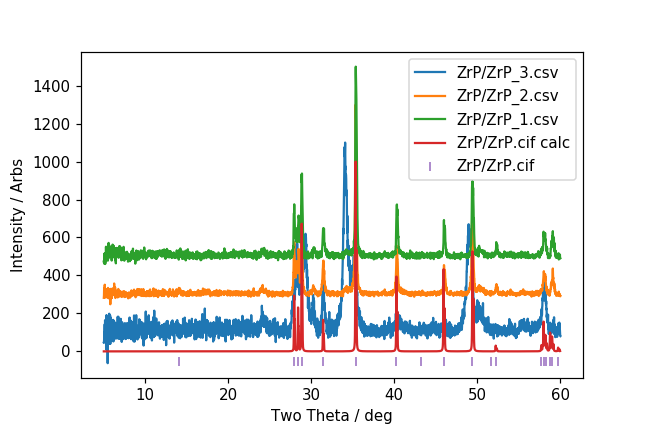

In [5]:
#
# This block shows reading a set of experimental datasets and comparing
# it to a simulated one. Appropriately scales all to the same maximum value.
#
# Any errors related to inability to load module "wx" are inert and arise because
# we are running GSASII in scripted mode.
#
%matplotlib notebook
import matplotlib.pyplot as plt
from pathlib import Path
# Read in all input csv files
spectra = {}
for file in Path('./ZrP').glob('*.csv'):
    spectra[str(file)] = readCSVCleanXY(file)
# compute global 2-Theta min, max, and min step size for the simulations
th2min = np.inf
th2max = -np.inf
th2step = np.inf
for s in spectra:
    th2min = (np.amin(spectra[s][:,1]) if np.amin(spectra[s][:,1])<th2min else th2min )
    th2max = (np.amax(spectra[s][:,1]) if np.amax(spectra[s][:,1])>th2max else th2max )
    th2min = (np.amin(np.diff(spectra[s][:,0])) if np.amin(np.diff(spectra[s][:,0]))<th2step else th2step )
# run all simulations
simspectra = {}
for file in Path('./ZrP').glob('*.cif'):
    simspectra[str(file)] = simulatePattern(str(file))
# First plot all experimental data
target = 1000.0
delta = 0.2*target
offset = 0.5*delta
for s in spectra:
    data = spectra[s]
    osf = getScaleFactor(data,target=target)
    plt.plot(data[:,0],osf*data[:,1]+offset,label=s)
    offset += delta
# Then plot all calculated patterns
for s in simspectra:
    sim = simspectra[s]
    osf = getScaleFactor(sim['pred'],target=target)
    plt.plot(sim['pred'][:,0],osf*sim['pred'][:,1],label=s + " calc")
    plt.plot(sim['refl'][:,0],osf*sim['refl'][:,1], '|', label=s)
plt.xlabel("Two Theta / deg")
plt.ylabel("Intensity / Arbs")
plt.legend()